In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn


In [2]:
df_join = pd.read_excel('../data/data_joined_16-23_no_new_buildings.xlsx')

In [131]:
df_infl = pd.read_excel('../data/constructed/inflation-rate-in-kazakhstan-2028.xlsx', sheet_name='Data')
df_infl['Year'] = pd.to_numeric(df_infl['Year'].str.replace('*',''))
df_infl=df_infl[pd.to_numeric(df_infl.Year)>=2016]

C:\Users\User\AppData\Local\Temp\ipykernel_10440\1026236143.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_infl['Year'] = pd.to_numeric(df_infl['Year'].str.replace('*',''))


In [323]:

def get_perc_from_base(row):
    if row['Year'] == 2016:
        return 1.0
    else:
        return (1+row['Value']/100)

df_infl['Multiplier'] = df_infl.apply(lambda x: get_perc_from_base(x),axis=1)

for elem in range(18, 18 + df_infl.__len__()):
    if elem != 18:
        df_infl.at[elem,'Multiplier'] = df_infl.at[elem,'Multiplier']*df_infl.at[elem-1,'Multiplier']
    
df_join = df_join.merge(df_infl[['Year','Multiplier']], left_on='YEAR',right_on='Year').drop(columns=['Year'])

C:\Users\User\AppData\Local\Temp\ipykernel_7460\1967267119.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_infl['Year'] = pd.to_numeric(df_infl['Year'].str.replace('*',''))


In [324]:
onehot = OneHotEncoder(sparse_output=False).fit(df_join[['Regions']])

df_join = df_join.join(pd.DataFrame(onehot.transform(df_join[['Regions']]), columns=onehot.get_feature_names_out()))

ValueError: columns overlap but no suffix specified: Index(['Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty', 'Regions_Auezov',
       'Regions_Bostandyq', 'Regions_Jetysu', 'Regions_Medeu',
       'Regions_Nauryzbai', 'Regions_Turksib'],
      dtype='object')

In [ ]:
df_join['price_adj'] = df_join['price']/df_join['Multiplier']
df_join['price_adj_per_area'] = df_join['price_adj']/df_join['area']
df_join['price_per_area'] = df_join['price']/df_join['area']

In [8]:
df_join.columns

Index(['Unnamed: 0', 'area', 'price', 'floor', 'year_built', 'region',
       'total_floor', 'Latitude', 'Longitude', 'YEAR', 'Regions', 'Multiplier',
       'Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty', 'Regions_Auezov',
       'Regions_Bostandyq', 'Regions_Jetysu', 'Regions_Medeu',
       'Regions_Nauryzbai', 'Regions_Turksib', 'price_adj',
       'price_adj_per_area', 'price_per_area'],
      dtype='object')

In [9]:
df_join.YEAR.value_counts()

2020    59756
2023    26590
2017    22916
2021    18991
2019     1211
2022      135
2016       91
2018       23
Name: YEAR, dtype: int64

try 2016 x 2017 x 2018 vs 2019

In [3]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, RandomForestRegressor

In [12]:
df_join.columns

Index(['Unnamed: 0', 'area', 'price', 'floor', 'year_built', 'region',
       'total_floor', 'Latitude', 'Longitude', 'YEAR', 'Regions', 'Multiplier',
       'Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty', 'Regions_Auezov',
       'Regions_Bostandyq', 'Regions_Jetysu', 'Regions_Medeu',
       'Regions_Nauryzbai', 'Regions_Turksib', 'price_adj',
       'price_adj_per_area', 'price_per_area'],
      dtype='object')

In [ ]:
df_join['year_built'] = df_join.year_built.apply(lambda x: int(x[:x.find(' ')]) if type(x)==str else x)

Age of the building will make more sence with respect to the age of the data collected

In [ ]:
df_join['building_age'] = df_join['YEAR'] - df_join['year_built']

<AxesSubplot: ylabel='price_adj_per_area'>

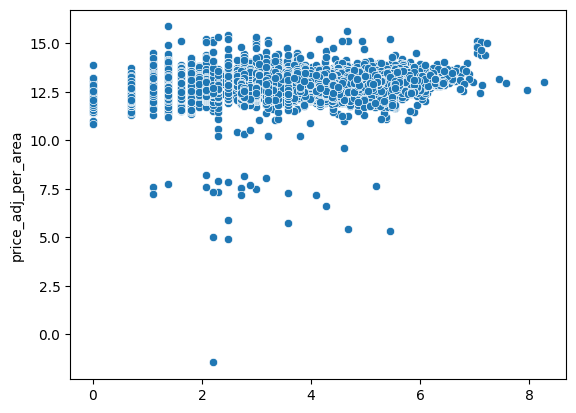

In [106]:
sns.scatterplot(x=np.log(df_join[(df_join['floor']>0)&(df_join['total_floor']>0)].floor * df_join[(df_join['floor']>0)&(df_join['total_floor']>0)].total_floor), y=np.log(df_join[(df_join['floor']>0)&(df_join['total_floor']>0)]['price_adj_per_area']))

In [123]:
df_join.groupby('YEAR')['price_adj_per_area'].mean()

YEAR
2016    336352.702794
2017    337483.304702
2018    317909.770735
2019    350714.733540
2020    353184.788808
2021    451746.977408
2022    426311.469469
2023    394282.503888
Name: price_adj_per_area, dtype: float64

In [129]:
df_join.groupby('YEAR', as_index=False).apply(lambda x: x.sample(20)).groupby('YEAR')['price_adj_per_area'].mean()

YEAR
2016    308710.061531
2017    311588.497417
2018    323402.617644
2019    316790.692254
2020    343861.936955
2021    460104.251066
2022    469352.600333
2023    355949.533048
Name: price_adj_per_area, dtype: float64

Index(['Unnamed: 0.1', 'Unnamed: 0', 'area', 'price', 'floor', 'year_built',
       'region', 'total_floor', 'Latitude', 'Longitude', 'YEAR', 'Regions',
       'Multiplier', 'Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty',
       'Regions_Auezov', 'Regions_Bostandyq', 'Regions_Jetysu',
       'Regions_Medeu', 'Regions_Nauryzbai', 'Regions_Turksib', 'price_adj',
       'price_adj_per_area', 'price_per_area', 'building_age',
       'log_price_adj_per_area'],
      dtype='object')

In [132]:
df_infl

,Year,Value,Unit
18,2016,14.56,in %
19,2017,7.43,in %
20,2018,6.03,in %
21,2019,5.24,in %
22,2020,6.80,in %
23,2021,8.00,in %
24,2022,14.96,in %
25,2023,14.83,in %
26,2024,8.55,in %
27,2025,6.19,in %


In [197]:
sample_means = df_join.groupby('YEAR', as_index=False).apply(lambda x: x.sample(20)).groupby('YEAR')['price_adj_per_area'].mean()

def get_extrapolated_mean_price_per_area_adj(row):
    if row['YEAR'] != 2016:
        collected_mean = sample_means[row['YEAR']]
        infl = df_infl[df_infl['Year']==row['YEAR']]['Value'].item()
        infl = 1 + infl/100
        return collected_mean * infl
    else: return sample_means[row['YEAR']]


In [198]:
df_join['extrapolated_mean_price_adj_per_area'] = df_join.apply(lambda x: get_extrapolated_mean_price_per_area_adj(x), axis=1)

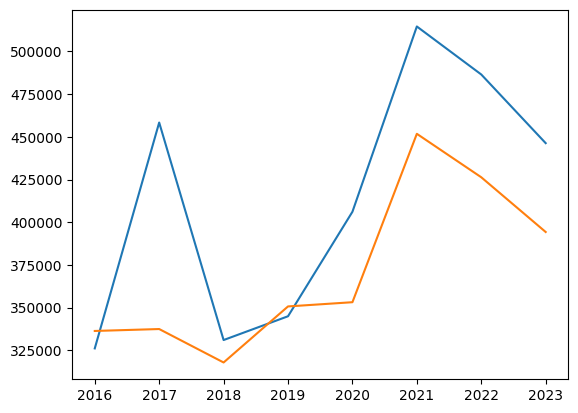

In [199]:
plt.plot(df_join.groupby('YEAR')[['extrapolated_mean_price_adj_per_area', 'price_adj_per_area']].mean())

In [200]:
PREDICTION_YEAR = 2023

In [236]:
x_train, y_train = df_join[df_join['YEAR'].isin(range(PREDICTION_YEAR-2, PREDICTION_YEAR))][[ 'floor', 'building_age', 'total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty', 'Regions_Auezov',
       'Regions_Bostandyq', 'Regions_Jetysu', 'Regions_Medeu',
       'Regions_Nauryzbai', 'Regions_Turksib','YEAR']], df_join[df_join['YEAR'].isin(range(PREDICTION_YEAR-2, PREDICTION_YEAR))]['price_adj_per_area']

In [237]:
x_test, y_test = df_join[df_join['YEAR'] == PREDICTION_YEAR][[ 'floor', 'building_age', 'total_floor', 'Latitude', 'Longitude','Regions_Alatau', 'Regions_Almaly', 'Regions_Almaty', 'Regions_Auezov',
       'Regions_Bostandyq', 'Regions_Jetysu', 'Regions_Medeu',
       'Regions_Nauryzbai', 'Regions_Turksib','YEAR']], df_join[df_join['YEAR'] == PREDICTION_YEAR]['price_adj_per_area']


In [238]:
from sklearn.preprocessing import StandardScaler

In [242]:
y_train, y_test = StandardScaler().fit_transform(y_train.to_numpy().reshape(-1, 1)), StandardScaler().fit_transform(y_test.to_numpy().reshape(-1, 1))

In [228]:
y_train, y_test = np.log(y_train), np.log(y_test)

Sent no cold entry data 

Decision Tree

In [245]:
maxv = (0,0)
iter_influence = []
for iter in range(2, 100):
    y_pred = DecisionTreeRegressor(max_leaf_nodes=iter).fit(x_train, y_train).predict(x_test)
    y_pred *= sample_means[PREDICTION_YEAR]/sample_means[x_test['YEAR']]
    score = R2Score()(torch.tensor(y_pred.to_numpy().flatten()), torch.tensor(y_test.flatten())).item()
    iter_influence.append([iter, score])
    if score > maxv[1]:
        maxv = (iter, score) 

In [246]:
maxv

(18, 0.3947216868400574)

In [204]:
maxv = (0,0)
iter_influence = []
for iter in range(2, 100):
    score = DecisionTreeRegressor(max_leaf_nodes=iter).fit(x_train, y_train).score(x_test, y_test)
    iter_influence.append([iter, score])
    if score > maxv[1]:
        maxv = (iter, score) 

In [205]:
maxv

(12, 0.22095311576542553)

<AxesSubplot: >

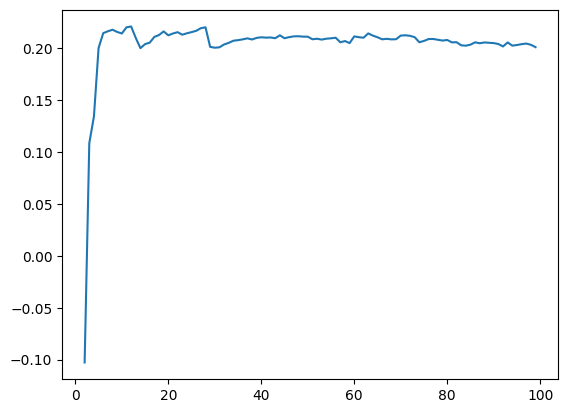

In [206]:
sns.lineplot(x=np.array(iter_influence)[:,0], y=np.array(iter_influence)[:,1])

RandomForest

In [247]:
maxv = (0,0)
for iter in range(2, 20):
    score = RandomForestRegressor(100,max_leaf_nodes = iter).fit(x_train, y_train).score(x_test, y_test)
    if score > maxv[1]:
        maxv = (iter, score) 

C:\Users\User\AppData\Local\Temp\ipykernel_10440\2421217637.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  score = RandomForestRegressor(100,max_leaf_nodes = iter).fit(x_train, y_train).score(x_test, y_test)
C:\Users\User\AppData\Local\Temp\ipykernel_10440\2421217637.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  score = RandomForestRegressor(100,max_leaf_nodes = iter).fit(x_train, y_train).score(x_test, y_test)
C:\Users\User\AppData\Local\Temp\ipykernel_10440\2421217637.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  score = RandomForestRegressor(100,max_leaf_nodes = iter).fit(x_train, y_train).score(x_test, y_test)
C:\Users\User\AppData\Local\

In [249]:
maxv

(18, 0.4041998924266875)

Ada Boost # covered on ML course

In [141]:
maxv = (0,0)
iter_influence = []
for iter in np.arange(1000, 10000, 100):
    score = AdaBoostRegressor(DecisionTreeRegressor(max_leaf_nodes = 6),n_estimators=iter, learning_rate=1/iter).fit(x_train, y_train).score(x_test, y_test)
    iter_influence.append([iter, score])
    if score > maxv[1]:
        maxv = (iter, score) 

KeyboardInterrupt: 

In [142]:
maxv

(1000, 0.21485095020045142)

<AxesSubplot: >

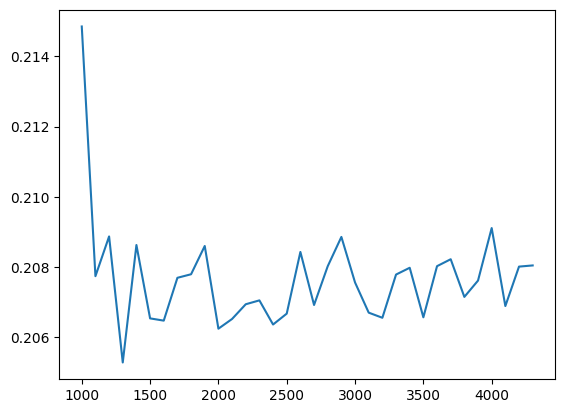

In [143]:
sns.lineplot(x=np.array(iter_influence)[:,0], y=np.array(iter_influence)[:,1])

Okey lets see what Gradient Boosting will show

In [ ]:
from functools import lru_cache

In [35]:
maxv = (0,0)
iter_influence = []
for iter in np.arange(1000, 1010, 10):
    score = GradientBoostingRegressor(n_estimators=iter).fit(x_train, y_train).score(x_test, y_test)
    iter_influence.append([iter, score])
    if score > maxv[1]:
        maxv = (iter, score) 

In [36]:
maxv

(1000, 0.36402903380809104)

<AxesSubplot: >

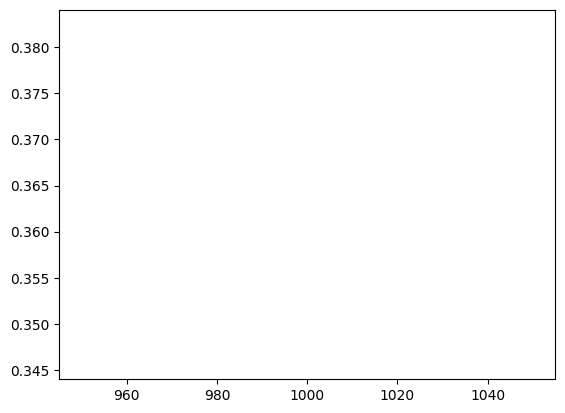

In [37]:
sns.lineplot(x=np.array(iter_influence)[:,0], y=np.array(iter_influence)[:,1])

Bagging

In [148]:
maxv = (0,0)
iter_influence = []
for iter in np.arange(2, 11, 1):
    score = BaggingRegressor(DecisionTreeRegressor(max_leaf_nodes=iter),n_estimators=1000).fit(x_train, y_train).score(x_test, y_test)
    iter_influence.append([iter, score])
    if score > maxv[1]:
        maxv = (iter, score) 

In [149]:
maxv

(10, 0.23682812781575535)

<AxesSubplot: >

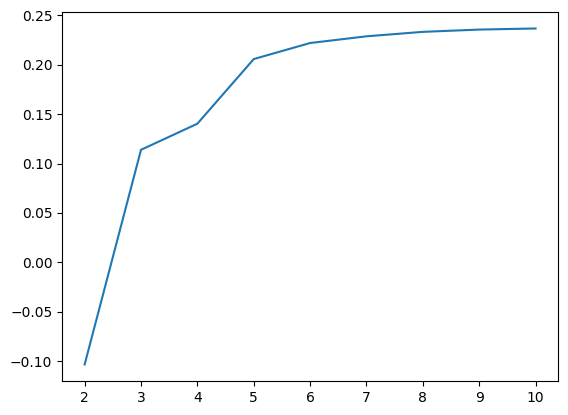

In [150]:
sns.lineplot(x=np.array(iter_influence)[:,0], y=np.array(iter_influence)[:,1])

Neural Network

In [330]:
from sklearn.neural_network import MLPRegressor

In [191]:
nn=MLPRegressor((8, 4),solver='adam', max_iter=50, verbose=True).fit(x_train, y_train)


Iteration 1, loss = 107.02969257
Iteration 2, loss = 4.94695276
Iteration 3, loss = 2.16431441
Iteration 4, loss = 1.69428506
Iteration 5, loss = 1.34494965
Iteration 6, loss = 1.14248808
Iteration 7, loss = 1.00995856
Iteration 8, loss = 0.80245269
Iteration 9, loss = 0.74396877
Iteration 10, loss = 0.70143993
Iteration 11, loss = 0.65794299
Iteration 12, loss = 0.61799723
Iteration 13, loss = 0.58672258
Iteration 14, loss = 0.55321374
Iteration 15, loss = 0.51832050
Iteration 16, loss = 0.48283745
Iteration 17, loss = 0.46167903
Iteration 18, loss = 0.43811273
Iteration 19, loss = 0.40334696
Iteration 20, loss = 0.39179977
Iteration 21, loss = 0.38296920
Iteration 22, loss = 0.34712197
Iteration 23, loss = 0.35875777
Iteration 24, loss = 0.31751400
Iteration 25, loss = 0.29696406
Iteration 26, loss = 0.30097190
Iteration 27, loss = 0.29456087
Iteration 28, loss = 0.30187876
Iteration 29, loss = 0.25066968
Iteration 30, loss = 0.27304400
Iteration 31, loss = 0.23655977
Iteration 32, l

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [192]:
nn.score(x_test, y_test)

0.42474515112197253

In [214]:
df_join['log_price_adj_per_area'] = np.log(df_join.price_adj_per_area)

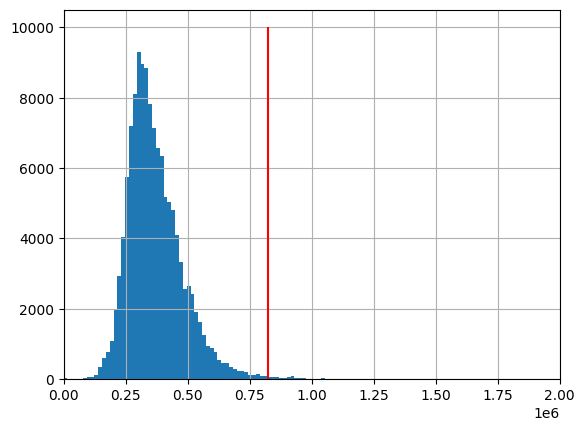

In [213]:
df_join.price_adj_per_area.hist(bins=500)

plt.xlim((0,2e6))

plt.vlines(x=df_join.price_adj_per_area.mean()+df_join.price_adj_per_area.std()*3.4, ymin=0, ymax=1e4, colors='red')

In [250]:
import torch
from torch import nn


In [251]:
x_test.shape

(26590, 15)

In [252]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(15, 32)
        self.fc2 = nn.Linear(32, 16)
        # self.fc3 = nn.Linear(16, 8)
        self.out = nn.Linear(16, 1)
    
    def forward(self, x):
        copy = x.copy()
        if type(copy) == pd.DataFrame:
            copy = torch.tensor(copy.values).float()
        copy = nn.functional.relu(self.fc1(copy))
        copy = nn.functional.relu(self.fc2(copy))
        # copy = nn.functional.relu(self.fc3(copy))
        return self.out(copy)



In [253]:
model = Model()

In [254]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [255]:
criterion = nn.L1Loss()

In [257]:
for epoch in range(10000):

    optimizer.zero_grad()
    
    y_pred = model(x_train)
    loss = criterion(y_pred.flatten(),  torch.tensor(y_train.flatten()))
    r2score = R2Score()(y_pred.flatten(),  torch.tensor(y_train.flatten()))
    loss.backward()
    optimizer.step()


    print(f'[{epoch + 1}] loss: {loss.item():.3f}', 'R^2', r2score.item())


[1] loss: 52.366 R^2 -2743.037109375
[2] loss: 51.437 R^2 -2646.615966796875
[3] loss: 50.509 R^2 -2551.921142578125
[4] loss: 49.580 R^2 -2458.948486328125
[5] loss: 48.651 R^2 -2367.697265625
[6] loss: 47.722 R^2 -2278.168212890625
[7] loss: 46.793 R^2 -2190.3603515625
[8] loss: 45.864 R^2 -2104.274169921875
[9] loss: 44.934 R^2 -2019.907470703125
[10] loss: 44.005 R^2 -1937.261474609375
[11] loss: 43.076 R^2 -1856.333251953125
[12] loss: 42.146 R^2 -1777.1236572265625
[13] loss: 41.217 R^2 -1699.63134765625
[14] loss: 40.287 R^2 -1623.8568115234375
[15] loss: 39.357 R^2 -1549.800537109375
[16] loss: 38.427 R^2 -1477.4613037109375
[17] loss: 37.497 R^2 -1406.83935546875
[18] loss: 36.567 R^2 -1337.935791015625
[19] loss: 35.636 R^2 -1270.7515869140625
[20] loss: 34.706 R^2 -1205.2855224609375
[21] loss: 33.775 R^2 -1141.5389404296875
[22] loss: 32.844 R^2 -1079.51220703125
[23] loss: 31.912 R^2 -1019.2061157226562
[24] loss: 30.981 R^2 -960.6207275390625
[25] loss: 30.049 R^2 -903.75

In [157]:
from torchmetrics import R2Score

In [260]:
with torch.no_grad():
        y_pred = model(x_test)
        loss = criterion(y_pred.flatten(),  torch.tensor(y_test.flatten()))
        r2score = R2Score()(y_pred.flatten(),  torch.tensor(y_test.flatten()))
        print('Loss Mae',loss.item())
        print('R^2', r2score.item())


Loss Mae 0.5007797888013856
R^2 0.21607857942581177


In [319]:
df_join.to_excel('../data/data_joined_16-23_no_new_buildings.xlsx')

In [320]:
df_join.shape

(129713, 26)